# Proof of concept for using crosstalk to manipulate output of circuit
- noise/error_rates example taken from ibm_challenge 2024 lab4

## imports

In [1]:
# Import all in one cell

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import RealAmplitudes
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import InstructionProperties
from qiskit.visualization import plot_distribution
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.primitives import StatevectorEstimator

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions
)

from qiskit.visualization import plot_histogram

## define fake backend and fake_noisy backend

In [2]:
#define coupling map
coupling_map = [[0,1],[1,0],[1,2],[2,1],[0,2],[2,0],[2,3],[3,2],[2,4],[4,2],[3,4],[4,3]]

In [3]:
fake_backend = GenericBackendV2(
    num_qubits=5,
    basis_gates=["id", "rz", "sx", "x", "cx"],
    coupling_map = coupling_map
  )

In [4]:
print(fake_backend.coupling_map)

[[0, 1], [1, 0], [1, 2], [2, 1], [0, 2], [2, 0], [2, 3], [3, 2], [2, 4], [4, 2], [3, 4], [4, 3]]


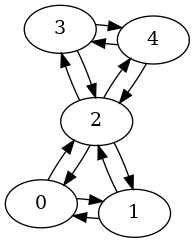

In [5]:
fake_backend.coupling_map.draw()

In [6]:
fake_noisy_backend = GenericBackendV2(
    num_qubits=5,
    basis_gates=["id", "rz", "sx", "x", "cx"],
    coupling_map = coupling_map
  )

In [7]:
print(fake_noisy_backend.target)

Target: Generic Target with 5 qubits
Number of qubits: 5
Instructions:
	id
		(0,):
			Duration: 5.0172e-08 sec.
			Error Rate: 9.944782482822101e-05
		(1,):
			Duration: 5.106e-08 sec.
			Error Rate: 9.788614893479064e-05
		(2,):
			Duration: 3.0858000000000004e-08 sec.
			Error Rate: 9.493460100584223e-05
		(3,):
			Duration: 5.4834e-08 sec.
			Error Rate: 9.24292040379777e-05
		(4,):
			Duration: 4.9284e-08 sec.
			Error Rate: 9.034645516353652e-05
	rz
		(0,):
			Duration: 0.0 sec.
			Error Rate: 0.0
		(1,):
			Duration: 0.0 sec.
			Error Rate: 0.0
		(2,):
			Duration: 0.0 sec.
			Error Rate: 0.0
		(3,):
			Duration: 0.0 sec.
			Error Rate: 0.0
		(4,):
			Duration: 0.0 sec.
			Error Rate: 0.0
	sx
		(0,):
			Duration: 5.9052000000000005e-08 sec.
			Error Rate: 9.30270070992786e-05
		(1,):
			Duration: 5.217e-08 sec.
			Error Rate: 9.745058151289973e-05
		(2,):
			Duration: 4.3734e-08 sec.
			Error Rate: 9.627246647617427e-05
		(3,):
			Duration: 4.884e-08 sec.
			Error Rate: 9.4565654

In [8]:
def update_error_rate(backend, error_rates):

    """Updates the error rates of the backend

    Parameters: 
        backend (BackendV2): Backend to update
        error_rates (dict): Dictionary of error rates

    Returns:    
        None
    """

    default_duration=1e-8
    if "default_duration" in error_rates:
        default_duration = error_rates["default_duration"]

    # Update the 1-qubit gate properties 
    for i in range(backend.num_qubits):
        qarg = (i,)
        if "rz_error" in error_rates:
            backend.target.update_instruction_properties('rz', qarg, InstructionProperties(error=error_rates["rz_error"], duration=default_duration))
        if "x_error" in error_rates:
            backend.target.update_instruction_properties('x', qarg, InstructionProperties(error=error_rates["x_error"], duration=default_duration))
        if "sx_error" in error_rates:
            backend.target.update_instruction_properties('sx', qarg, InstructionProperties(error=error_rates["sx_error"], duration=default_duration)) 
        if "measure_error" in error_rates:
            backend.target.update_instruction_properties('measure', qarg, InstructionProperties(error=error_rates["measure_error"], duration=default_duration))            
    
    # Update the 2-qubit gate properties (CX gate) for all edges in the chosen coupling map
    if "cx_error" in error_rates:    
        for edge in backend.coupling_map:
            backend.target.update_instruction_properties('cx', tuple(edge), InstructionProperties(error=error_rates["cx_error"], duration=default_duration))

In [9]:
error_rates = {
  #"default_duration": 1e-8,
  #"rz_error": 1e-8,
  "x_error": 1e-4,
  #"sx_error": 1e-8,
  #"measure_error": 1e-8,
  "cx_error": 2e-2
}

update_error_rate(fake_noisy_backend, error_rates)

In [10]:
print(fake_noisy_backend.target)

Target: Generic Target with 5 qubits
Number of qubits: 5
Instructions:
	id
		(0,):
			Duration: 5.0172e-08 sec.
			Error Rate: 9.944782482822101e-05
		(1,):
			Duration: 5.106e-08 sec.
			Error Rate: 9.788614893479064e-05
		(2,):
			Duration: 3.0858000000000004e-08 sec.
			Error Rate: 9.493460100584223e-05
		(3,):
			Duration: 5.4834e-08 sec.
			Error Rate: 9.24292040379777e-05
		(4,):
			Duration: 4.9284e-08 sec.
			Error Rate: 9.034645516353652e-05
	rz
		(0,):
			Duration: 0.0 sec.
			Error Rate: 0.0
		(1,):
			Duration: 0.0 sec.
			Error Rate: 0.0
		(2,):
			Duration: 0.0 sec.
			Error Rate: 0.0
		(3,):
			Duration: 0.0 sec.
			Error Rate: 0.0
		(4,):
			Duration: 0.0 sec.
			Error Rate: 0.0
	sx
		(0,):
			Duration: 5.9052000000000005e-08 sec.
			Error Rate: 9.30270070992786e-05
		(1,):
			Duration: 5.217e-08 sec.
			Error Rate: 9.745058151289973e-05
		(2,):
			Duration: 4.3734e-08 sec.
			Error Rate: 9.627246647617427e-05
		(3,):
			Duration: 4.884e-08 sec.
			Error Rate: 9.4565654

## define our dummy circuit

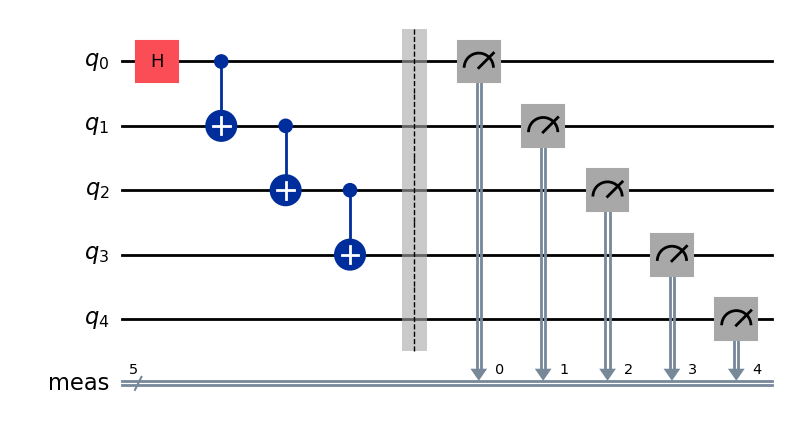

In [11]:
# Make a quantum circuit -> GHZ state
qc = QuantumCircuit(5)#Add your code
qc.h(0)
qc.cx(0,1)
qc.cx(1,2)
qc.cx(2,3)
qc.measure_all()

qc.draw("mpl")

## use fake backend

In [12]:
sampler = Sampler(fake_backend)
pm = generate_preset_pass_manager(optimization_level=0, backend=fake_backend, seed_transpiler=0)

In [13]:
qc_isa = pm.run(qc)

In [14]:
pub = (qc_isa)
job_sampler = sampler.run([pub], shots=1000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()

print(counts_sampler)

{'00000': 513, '01111': 470, '00001': 2, '00011': 1, '01110': 6, '01011': 1, '01000': 1, '00111': 3, '01101': 1, '00100': 2}


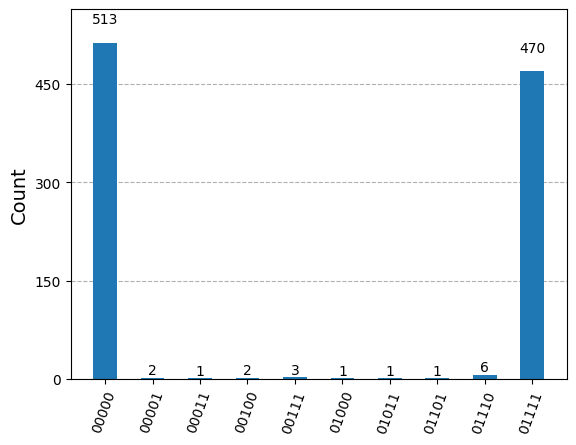

In [15]:
plot_histogram(counts_sampler)

## use fake noisy backend

In [16]:
sampler = Sampler(fake_noisy_backend)
pm = generate_preset_pass_manager(optimization_level=0, backend=fake_noisy_backend, seed_transpiler=0)

In [17]:
qc_isa_noise = pm.run(qc)

In [18]:
pub = (qc_isa_noise)
job_sampler = sampler.run([pub], shots=1000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()

print(counts_sampler)

{'00000': 464, '01111': 477, '01011': 5, '00001': 12, '01110': 8, '01000': 8, '00010': 1, '01100': 4, '00111': 8, '01101': 3, '00011': 8, '00100': 2}


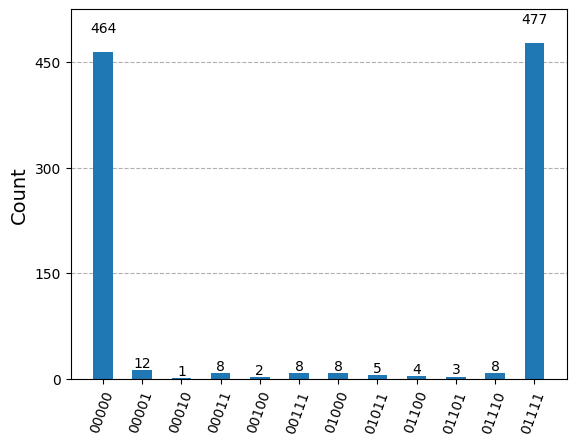

In [19]:
plot_histogram(counts_sampler)

## manipulate circuit 1q-gate

In [21]:
qc_manipulate = QuantumCircuit(5,5)

In [22]:
for i in range(0,10000):
    qc_manipulate.h(4)

In [23]:
qc_manipulate = qc_manipulate.compose(qc)
qc_manipulate.measure_all()

In [24]:
#qc_manipulate.draw("mpl")

In [25]:
qc_isa_tempered = pm.run(qc_manipulate)

In [26]:
#qc_isa_tempered.draw("mpl")

In [27]:
pub = (qc_isa_tempered)
job_sampler = sampler.run([pub], shots=1000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()

print(counts_sampler)

{'01111': 374, '00000': 343, '11111': 97, '11011': 4, '11110': 2, '10000': 112, '11100': 3, '01011': 4, '10010': 4, '01110': 6, '10111': 1, '00100': 1, '00111': 10, '01100': 9, '01000': 3, '00001': 9, '10100': 2, '01101': 4, '00010': 3, '10001': 2, '00011': 3, '11000': 3, '11101': 1}


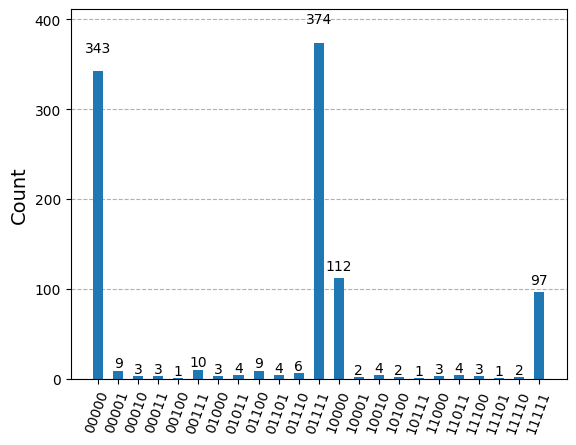

In [28]:
plot_histogram(counts_sampler)

## manipulate circuit 2q-gate

In [29]:
qc_manipulate2 = QuantumCircuit(5,5)

In [30]:
for i in range(0,1000):
    qc_manipulate2.cx(3,4)

In [31]:
qc_manipulate2 = qc_manipulate2.compose(qc)
qc_manipulate2.measure_all()

In [32]:
qc_isa_tempered2 = pm.run(qc_manipulate2)

In [33]:
pub = (qc_isa_tempered2)
job_sampler = sampler.run([pub], shots=1000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()

print(counts_sampler)

{'00111': 133, '11111': 109, '00000': 109, '11000': 112, '01111': 114, '01000': 114, '10111': 127, '10000': 112, '00011': 6, '00110': 6, '10110': 7, '01010': 2, '01110': 3, '00001': 5, '11011': 5, '11100': 6, '11101': 2, '01001': 2, '11110': 4, '01011': 2, '00100': 2, '10011': 3, '11001': 3, '10100': 4, '01100': 1, '00101': 1, '00010': 1, '11010': 2, '10101': 2, '10010': 1}


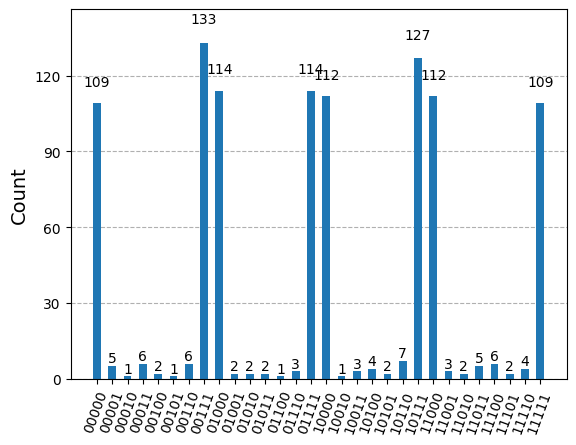

In [34]:
plot_histogram(counts_sampler)